# 🧠 Entrenamiento del Modelo - Sign2Speech


En este notebook se entrena el modelo de clasificación encargado de reconocer palabras individuales del lenguaje de signos a partir de secuencias de landmarks extraídas previamente.

Los datos utilizados provienen del dataset preprocesado y almacenado en Kaggle en el notebook anterior. El modelo se entrena utilizando secuencias de tamaño fijo, con una arquitectura basada en redes neuronales profundas adaptadas a la estructura de los datos de entrada.

El objetivo es obtener un modelo eficiente, ligero y preciso, capaz de ejecutarse posteriormente en un entorno de inferencia optimizado (Edge TPU). Se registran las métricas de rendimiento y se guarda el modelo en formato TensorFlow y TFLite.

<div style="color: red; font-weight: bold;">
IMPORTANTE: Este Notebook fue ejecutado en la maquina virtual GCP con versiones antiguas de tensorflow.
</div>

In [1]:
# 📦 Librerías estándar
import os
import sys
import glob
import math
import gc

# 📊 Manejo de datos
import numpy as np
import pandas as pd

# 🧠 Machine Learning
import tensorflow as tf
import sklearn
from sklearn.model_selection import train_test_split, GroupShuffleSplit 

# 📈 Visualización
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sn

# 🛠️ Utilidades
from tqdm.notebook import tqdm
import scipy


import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import layers

2025-06-28 22:28:14.067306: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-06-28 22:28:14.067332: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## 📥 Carga del Dataset Preprocesado

Se cargan los arrays `.npy` generados en el paso de preprocesamiento. Aunque ya se había realizado un `GroupShuffleSplit`, en este notebook se vuelve a hacer la división `train/validation` utilizando `train_test_split` con **estratificación**, para garantizar una distribución balanceada de clases y tener mayor control desde este entorno.


In [2]:
!unzip Archive.zip

Archive:  Archive.zip
  inflating: y (1).npy               
  inflating: __MACOSX/._y (1).npy    
  inflating: X.npy                   
  inflating: __MACOSX/._X.npy        


In [2]:
# Carga de datos desde los archivos generados previamente
X = np.load("X.npy")  
y = np.load("y.npy")  

# División en entrenamiento y validación (90% / 10%) con estratificación
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.1,       # 10% de los datos para validación
    random_state=42,     # Reproducibilidad
    stratify=y           # Mantiene la distribución de clases
)



## 🧱 Definición del Modelo - `get_cv1_model`

Se define una arquitectura basada en `TimeDistributed Dense` y `Conv1D`, diseñada para aprender representaciones temporales a partir de secuencias de landmarks 3D.

Esta arquitectura combina:
- Capas densas distribuidas por tiempo.
- Convoluciones 1D para extraer patrones temporales.
- Pooling global y una pila densa final para clasificación.

El objetivo es obtener un modelo preciso y ligero compatible con despliegue posterior en Edge TPU.


In [9]:
def get_cv1_model(input_shape=(64, 88, 3), num_classes=250):
    # Entrada del modelo: secuencia de 64 frames, 88 landmarks, 3 dimensiones (x, y, z)
    inputs = tf.keras.Input(shape=input_shape)

    # Aplanamos landmarks por frame: (64, 88*3)
    x = layers.Reshape((64, 88*3))(inputs)

    # Capa densa aplicada a cada frame (TimeDistributed)
    x = layers.TimeDistributed(layers.Dense(512, activation="relu"))(x)
    x = layers.TimeDistributed(layers.Dense(256, activation="relu"))(x)
    x = layers.TimeDistributed(layers.Dense(128, activation="relu"))(x)

    # Convoluciones 1D sobre el eje temporal (frames)
    x = layers.Conv1D(256, 3, padding="same", activation="relu")(x)
    x = layers.Conv1D(128, 3, padding="same", activation="relu")(x)

    # Pooling global para obtener una representación fija
    x = layers.GlobalAveragePooling1D()(x)

    # Capas densas finales para clasificación
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dense(64, activation="relu")(x)

    # Capa de salida con softmax para clasificación multiclase
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = tf.keras.Model(inputs, outputs)
    return model


In [ ]:
# Compilación del Modelo

# Crear el modelo
modelf2 = get_cv1_model()

# Compilar con Adam y entropía cruzada categórica (etiquetas como enteros)
modelf2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


In [8]:
# Entrenamiento del modelo
final2 = modelf2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),  # Evaluación en validación en cada época
    epochs=100,                      # Máximo de 100 épocas
    batch_size=64,                  # Tamaño del batch
    callbacks=get_callbacks(),      # Callbacks personalizados (early stopping, checkpoint, etc.)
    verbose=1                        # Mostrar progreso
)


2025-06-28 22:29:11.950535: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 5746599936 exceeds 10% of free system memory.
2025-06-28 22:29:14.185013: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
1329/1329 [==============================] - 48s 36ms/step - loss: 5.2460 - accuracy: 0.0109 - val_loss: 4.8541 - val_accuracy: 0.0296
Epoch 2/100
1329/1329 [==============================] - 47s 35ms/step - loss: 4.6240 - accuracy: 0.0447 - val_loss: 4.4530 - val_accuracy: 0.0568
Epoch 3/100
1329/1329 [==============================] - 47s 36ms/step - loss: 4.2938 - accuracy: 0.0796 - val_loss: 4.0840 - val_accuracy: 0.1048
Epoch 4/100
1329/1329 [==============================] - 47s 36ms/step - loss: 3.8656 - accuracy: 0.1319 - val_loss: 3.7531 - val_accuracy: 0.1474
Epoch 5/100
1329/1329 [==============================] - 47s 36ms/step - loss: 3.5235 - accuracy: 0.1804 - val_loss: 3.3949 - val_accuracy: 0.2055
Epoch 6/100
1329/1329 [==============================] - 47s 35ms/step - loss: 3.2823 - accuracy: 0.2211 - val_loss: 3.2248 - val_accuracy: 0.2318
Epoch 7/100
1329/1329 [==============================] - 48s 36ms/step - loss: 3.0777 - accuracy: 0.2577 - val_loss: 3

## 📊 Visualización del Proceso de Entrenamiento

Se grafican las curvas de precisión (`accuracy`) y pérdida (`loss`) tanto para el conjunto de entrenamiento como para validación, con el fin de analizar el comportamiento del modelo y detectar posibles síntomas de overfitting o underfitting.


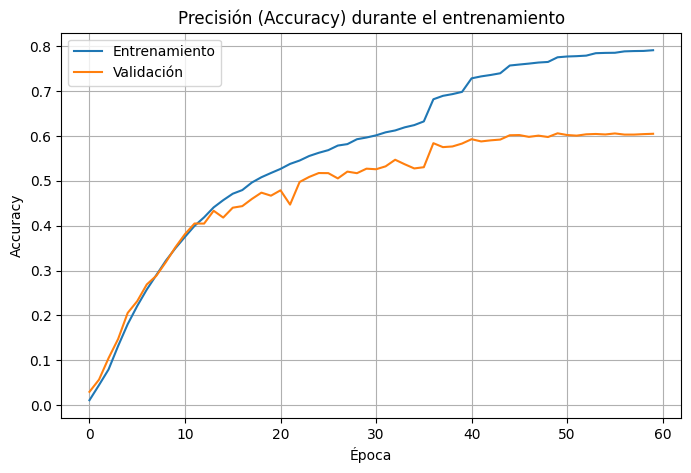

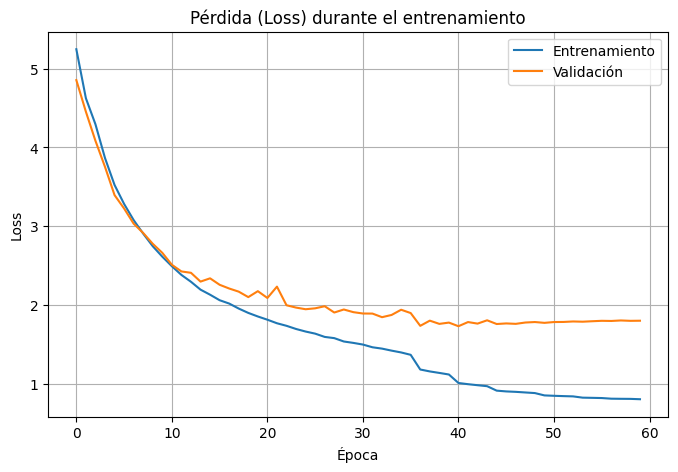

In [9]:
hist = final2.history 
plt.figure(figsize=(8, 5))
plt.plot(hist['accuracy'], label='Entrenamiento')
plt.plot(hist['val_accuracy'], label='Validación')
plt.title('Precisión (Accuracy) durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot de loss y val_loss
plt.figure(figsize=(8, 5))
plt.plot(hist['loss'], label='Entrenamiento')
plt.plot(hist['val_loss'], label='Validación')
plt.title('Pérdida (Loss) durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [11]:
# Mostrar el resumen del modelo
modelf2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 88, 3)]       0         
_________________________________________________________________
reshape (Reshape)            (None, 64, 264)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 64, 512)           135680    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 64, 256)           131328    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 64, 128)           32896     
_________________________________________________________________
conv1d (Conv1D)              (None, 64, 256)           98560     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 64, 128)           98432 

## 📦 Conversión del Modelo a TFLite (Cuantización Parcial)

Se convierte el modelo `modelf2` a formato `.tflite` con cuantización por defecto (`Optimize.DEFAULT`). Al no usarse `representative_dataset`, solo los pesos son cuantizados (activaciones siguen en float32), generando un modelo **parcialmente int8**, compatible con entornos donde no se requiere cuantización total.

Este modelo es útil como versión intermedia o de fallback antes de optimizar para Edge TPU.


In [27]:
# Convertir el modelo a formato TFLite con cuantización parcial
converter = tf.lite.TFLiteConverter.from_keras_model(modelf2)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Desactivar ejecución ansiosa para compatibilidad
modelf2._run_eagerly = False

# Generar el modelo tflite
tflite_model = converter.convert()

# Guardar en disco
with open("model_quant_fallback.tflite", "wb") as f:
    f.write(tflite_model)


2025-06-27 17:00:10.908773: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmp/tmp1t4bny08/assets


2025-06-27 17:00:11.856067: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2025-06-27 17:00:11.856234: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2025-06-27 17:00:11.863176: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:1137] Optimization results for grappler item: graph_to_optimize
  function_optimizer: function_optimizer did nothing. time = 0.008ms.
  function_optimizer: function_optimizer did nothing. time = 0.001ms.

2025-06-27 17:00:12.150817: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:351] Ignored output_format.
2025-06-27 17:00:12.150856: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:354] Ignored drop_control_dependency.
2025-06-27 17:00:12.185315: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:210] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
